# N2EX

N2EX day ahead auction prices daily GBP

In [1]:
#from IPython.core.debugger import set_trace

import pandas as pd
import numpy as np
from tqdm import tqdm, trange

import matplotlib.pyplot as plt

import time

# xgboost regressor can give a warning
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn import linear_model

C:\Users\joeba\Anaconda3\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Get this and last years day ahead auction prices data

In [2]:
dirpath = r'C:\Users\joeba\OneDrive\Documents\ML\n2ex'

In [3]:
# get this and last years prices
df = pd.read_excel(dirpath+'/n2ex-day-ahead-auction-prices_2022_daily_gbp.xls', index_col=0, skiprows=2)
df = df.append(pd.read_excel(dirpath+'/n2ex-day-ahead-auction-prices_2021_daily_gbp.xls', index_col=0, skiprows=2))
df.columns = ['Price']
df.sort_index(axis=0, inplace=True)

In [4]:
# xls comes with prices formatted with ',' instead of '.' - function to clean prices formatted with ',' to decimals
def clean_price(s):
    a = int(''.join(s.split(',')[0])) # 12
    b = int(''.join(s.split(',')[1])) # 34
    
    return a+(b/100)

# quick test
clean_price('12,34')

12.34

In [5]:
# clean up df - print the top 100 rows of the df
df['Price'] = df['Price'].apply(clean_price)
print(df.dtypes)
print(df.shape)
df.head(100)

Price    float64
dtype: object
(435, 1)


,Price
2021-01-01,61.49
2021-01-02,64.32
2021-01-03,58.68
2021-01-04,60.70
2021-01-05,60.88
...,...
2021-04-06,53.92
2021-04-07,63.50
2021-04-08,61.47
2021-04-09,65.42


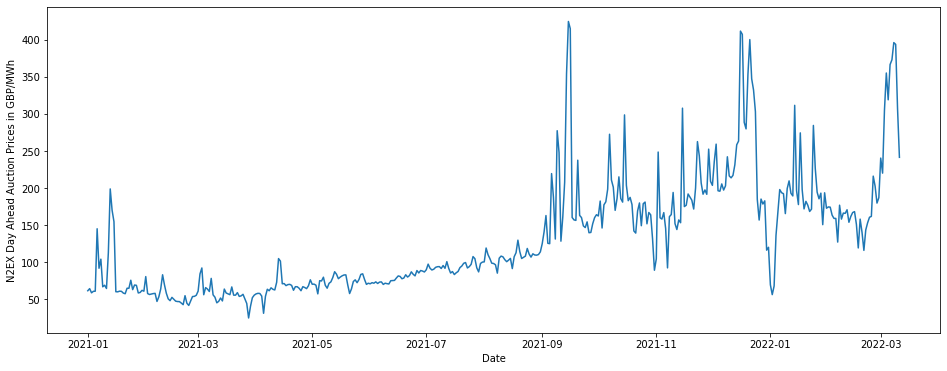

In [6]:
# quick plot the entire series
plt.figure(figsize=(16,6))
plt.plot(df['Price'])
plt.xlabel('Date')
plt.ylabel('N2EX Day Ahead Auction Prices in GBP/MWh')
plt.show()

Transform to an ML problem

In [7]:
df['Target'] = df['Price'].shift(-1)
df.dropna(inplace=True)
df.head(10)

,Price,Target
2021-01-01,61.49,64.32
2021-01-02,64.32,58.68
2021-01-03,58.68,60.70
2021-01-04,60.70,60.88
2021-01-05,60.88,145.08
2021-01-06,145.08,91.80
2021-01-07,91.80,104.06
2021-01-08,104.06,66.81
2021-01-09,66.81,68.92
2021-01-10,68.92,64.53


In [8]:
print(np.max(df['Price']), np.max(df['Target']))

424.61 424.61


In [9]:
df.tail()

,Price,Target
2022-03-06,366.44,372.92
2022-03-07,372.92,396.09
2022-03-08,396.09,393.69
2022-03-09,393.69,306.93
2022-03-10,306.93,241.40


In [10]:
def train_test_split(data, pc=0.2):
    data = data.values
    n = int(len(data) * (1-pc))
    return data[:n], data[n:]

In [11]:
train, test = train_test_split(df)

In [12]:
print(train.shape, test.shape)

(347, 2) (87, 2)


In [13]:
train

array([[ 61.49,  64.32],
       [ 64.32,  58.68],
       [ 58.68,  60.7 ],
       [ 60.7 ,  60.88],
       [ 60.88, 145.08],
       [145.08,  91.8 ],
       [ 91.8 , 104.06],
       [104.06,  66.81],
       [ 66.81,  68.92],
       [ 68.92,  64.53],
       [ 64.53, 112.93],
       [112.93, 198.79],
       [198.79, 170.03],
       [170.03, 154.62],
       [154.62,  60.15],
       [ 60.15,  60.01],
       [ 60.01,  60.91],
       [ 60.91,  60.7 ],
       [ 60.7 ,  58.32],
       [ 58.32,  57.47],
       [ 57.47,  64.84],
       [ 64.84,  64.82],
       [ 64.82,  75.65],
       [ 75.65,  62.99],
       [ 62.99,  69.2 ],
       [ 69.2 ,  68.79],
       [ 68.79,  58.49],
       [ 58.49,  59.17],
       [ 59.17,  62.02],
       [ 62.02,  60.86],
       [ 60.86,  80.56],
       [ 80.56,  57.68],
       [ 57.68,  56.43],
       [ 56.43,  57.07],
       [ 57.07,  57.65],
       [ 57.65,  57.94],
       [ 57.94,  47.07],
       [ 47.07,  53.34],
       [ 53.34,  63.9 ],
       [ 63.9 ,  83.03],


In [14]:
X = train[:,:-1]
y = train[:,-1]

model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(X,y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [15]:
test[0]

array([258.29, 263.37])

In [16]:
val = np.array(test[0,0].reshape(1,-1))
val

array([[258.29]])

In [17]:
pred = model.predict(val)
print(pred[0])

196.33237


Predict

In [18]:
def xgb_predict(train, val):
    train = np.array(train)
    X, y = train[:,:-1], train[:,-1]

    model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
    model.fit(X,y)
    
    val = np.array(val.reshape(1,-1))
    pred = model.predict(val)
    return pred[0]

xgb_predict(train, test[0,0])

196.33237

In [19]:
def walk_forward(data, pc):
    
    predictions = []
    
    train, test = train_test_split(data, pc)
    
    history = [x for x in train]
    
    for i in range(len(test)):
        test_X, test_y = test[i:, :-1], test[i, -1]
        
        pred = xgb_predict(history, test_X[0])
        predictions.append(pred)
        
        history.append(test[i])
        
    error = mean_squared_error(test[:,-1], predictions, squared=False)
        
    return error, test[:, -1], predictions 

In [20]:
%%time
error, y, pred = walk_forward(df, 0.2)

C:\Users\joeba\Anaconda3\lib\site-packages\xgboost\core.py:444: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Wall time: 28.9 s


In [21]:
print(error)

64.02694371079217


In [22]:
df2 = pd.DataFrame(test, columns=['Actual', 'Target'])
df2

,Actual,Target
0,258.29,263.37
1,263.37,411.62
2,411.62,407.21
3,407.21,288.53
4,288.53,279.75
...,...,...
82,366.44,372.92
83,372.92,396.09
84,396.09,393.69
85,393.69,306.93


In [23]:
df2['Pred']=pred
df2

,Actual,Target,Pred
0,258.29,263.37,196.332367
1,263.37,411.62,243.228073
2,411.62,407.21,160.261490
3,407.21,288.53,407.210175
4,288.53,279.75,203.659760
...,...,...,...
82,366.44,372.92,318.965515
83,372.92,396.09,372.915466
84,396.09,393.69,347.330505
85,393.69,306.93,393.689301


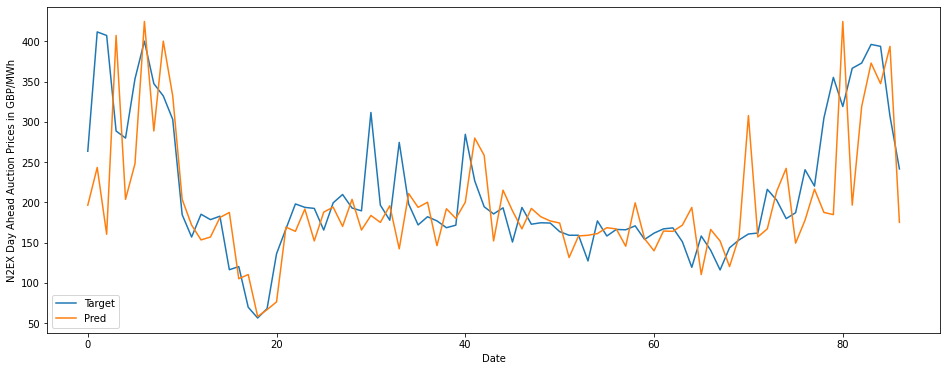

In [24]:
plt.figure(figsize=(16,6))
plt.plot(df2['Target'], label='Target')
plt.plot(df2['Pred'], label='Pred')
plt.xlabel('Date')
plt.ylabel('N2EX Day Ahead Auction Prices in GBP/MWh')
plt.legend()
plt.show()

Moving Average

In [25]:
# start with rolling average windows of 30, 10 and 5
df['rolling_long'] = df['Price'].rolling(30, min_periods=1, center=True).mean()
df['rolling_mid'] = df['Price'].rolling(10, min_periods=1, center=True).mean()
df['rolling_short'] = df['Price'].rolling(5, min_periods=1, center=True).mean()

df['ma_w_long'] = np.NaN
df['ma_w_mid'] = np.NaN
df['ma_w_short'] = np.NaN
df['Predicted'] = np.NaN
df['error'] = np.NaN
    

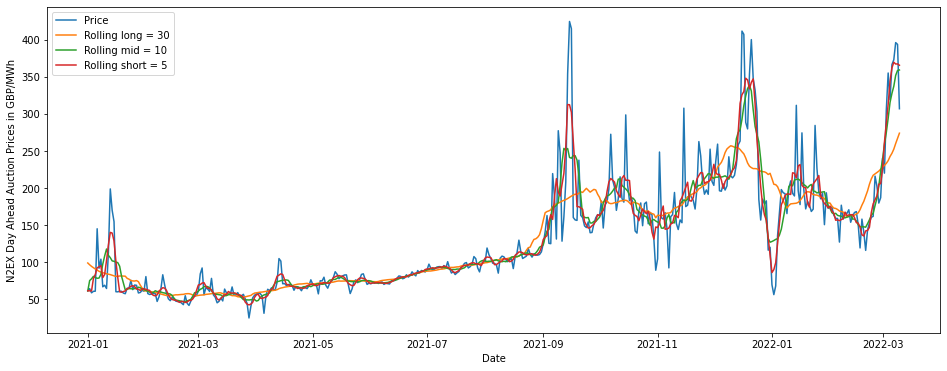

In [26]:
plt.figure(figsize=(16,6))
plt.plot(df['Price'], label='Price')
plt.plot(df['rolling_long'], label='Rolling long = 30')
plt.plot(df['rolling_mid'], label='Rolling mid = 10')
plt.plot(df['rolling_short'], label='Rolling short = 5')
plt.xlabel('Date')
plt.ylabel('N2EX Day Ahead Auction Prices in GBP/MWh')
plt.legend()
plt.show()

In [27]:
start = 300
df2 = df.iloc[:start,:].copy()


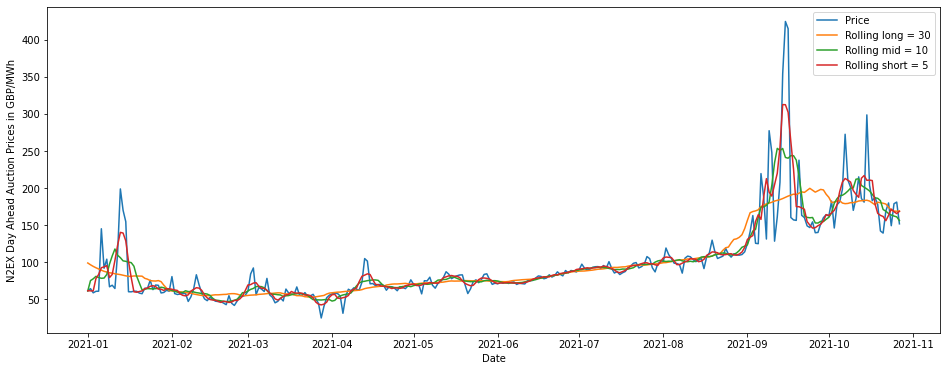

In [28]:
plt.figure(figsize=(16,6))
plt.plot(df2['Price'], label='Price')
plt.plot(df2['rolling_long'], label='Rolling long = 30')
plt.plot(df2['rolling_mid'], label='Rolling mid = 10')
plt.plot(df2['rolling_short'], label='Rolling short = 5')
plt.xlabel('Date')
plt.ylabel('N2EX Day Ahead Auction Prices in GBP/MWh')
plt.legend()
plt.show()

In [41]:



def searching_moving_average(data, start):

    # back to a day before start
    data2 = data.iloc[:,:].copy()
    data2.reset_index(inplace=True)
        
    # linear regression object
    regr = linear_model.LinearRegression()
    
    # run through the "test" data
    for i in range(start, len(data2)):
        
        # take a copy of the data up to i
        data_n = data2.iloc[:i,:].copy()
        
        # check parameters
        best_error = 1.23E9
        
        # search over a range of moving average window sizes
        for ma_w_a in range(30, 10, -5):
            for ma_w_b in range(10, 5, -2):
                for ma_w_c in range(5, 2, -1):
                    
                    # reset the moving average windows
                    data_n['rolling_long'] = data_n['Price'].rolling(ma_w_a, min_periods=1, center=True).mean()
                    data_n['rolling_mid'] = data_n['Price'].rolling(ma_w_b, min_periods=1, center=True).mean()
                    data_n['rolling_short'] = data_n['Price'].rolling(ma_w_c, min_periods=1, center=True).mean()
                    
                    # fit multiple regression on training set
                    regr.fit(data_n[['rolling_long', 'rolling_mid', 'rolling_short']], data_n[['Price']])
                    #print(regr.coef_)
                    
                    # fit the best regressor to todays price
                    pred1 = regr.predict([[data_n.loc[i-1, 'rolling_long'], 
                                           data_n.loc[i-1, 'rolling_mid'], 
                                           data_n.loc[i-1, 'rolling_short']]])[0][0]
                    
                    error1 = np.abs(pred1 - data_n.loc[i-1,'Price'])
                    
                    if error1 < best_error:
                        
                        best_error = error1
                        
                        data2.loc[i-1, 'ma_w_long'] = ma_w_a
                        data2.loc[i-1, 'ma_w_mid'] = ma_w_b
                        data2.loc[i-1, 'ma_w_short'] = ma_w_c 
                        
                        pred2 = regr.predict([[data_n.loc[i-1, 'rolling_long']+regr.coef_[0][0], 
                                               data_n.loc[i-1, 'rolling_mid']+regr.coef_[0][1], 
                                               data_n.loc[i-1, 'rolling_short']+regr.coef_[0][2]]])[0][0]
                        data2.loc[i, 'Predicted'] = pred2
                        
                        error2 = np.abs(pred2 - data_n.loc[i-1,'Target'])
                        data2.loc[i, 'error'] = error2     
                    
    return data2

df2 = searching_moving_average(df, 300)

In [42]:
df2.tail(40)

,index,Price,Target,rolling_long,rolling_mid,rolling_short,ma_w_long,ma_w_mid,ma_w_short,Predicted,error
394,2022-01-30,193.57,172.74,180.943333,182.868000,176.9040,15.0,6.0,4.0,164.374218,29.195782
395,2022-01-31,172.74,174.52,179.959667,176.112000,173.1160,15.0,6.0,4.0,184.720075,11.980075
396,2022-02-01,174.52,174.16,179.642667,172.568000,175.6960,15.0,6.0,3.0,175.800326,1.280326
397,2022-02-02,174.16,163.49,175.529667,166.730000,168.7880,15.0,10.0,3.0,176.809795,2.649795
398,2022-02-03,163.49,159.03,172.908667,165.104000,166.0380,15.0,8.0,3.0,175.799569,12.309569
399,2022-02-04,159.03,158.99,172.449000,165.853000,156.5560,20.0,6.0,3.0,168.640284,9.610284
400,2022-02-05,158.99,127.11,171.062667,163.118000,157.0920,30.0,8.0,4.0,161.036247,2.046247
401,2022-02-06,127.11,176.84,169.031333,162.426000,156.0100,20.0,10.0,3.0,160.955359,33.845359
402,2022-02-07,176.84,158.08,168.199667,162.042000,157.4480,15.0,6.0,4.0,140.905269,35.934731
403,2022-02-08,158.08,166.22,167.587333,160.008000,158.8140,15.0,10.0,4.0,158.423857,0.343857


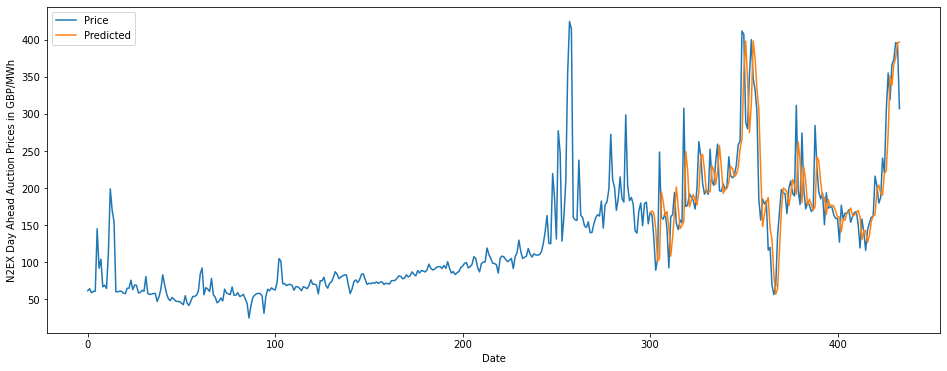

In [44]:
plt.figure(figsize=(16,6))
plt.plot(df2['Price'], label='Price')
plt.plot(df2['Predicted'], label='Predicted')
plt.xlabel('Date')
plt.ylabel('N2EX Day Ahead Auction Prices in GBP/MWh')
plt.legend()
plt.show()